Building prefix dict from the default dictionary ...
DEBUG:jieba:Building prefix dict from the default dictionary ...
Dumping model to file cache /tmp/jieba.cache
DEBUG:jieba:Dumping model to file cache /tmp/jieba.cache
Loading model cost 4.291 seconds.
DEBUG:jieba:Loading model cost 4.291 seconds.
Prefix dict has been built successfully.
DEBUG:jieba:Prefix dict has been built successfully.


<Axes: xlabel='label'>

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 25945 (\N{CJK UNIFIED IDEOGRAPH-6559}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 32946 (\N{CJK UNIFIED IDEOGRAPH-80B2}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 31185 (\N{CJK UNIFIED IDEOGRAPH-79D1}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 25216 (\N{CJK UNIFIED IDEOGRAPH-6280}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 31038 (\N{CJK UNIFIED IDEOGRAPH-793E}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 20250 (\N{CJK UNIFIED IDEOGRAPH-4F

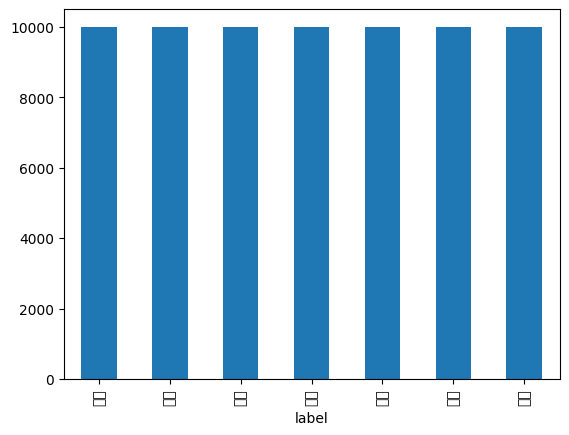

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['font.sans-serif'] = ['KaiTi']
plt.rcParams['axes.unicode_minus'] = False
import jieba
stop_list=pd.read_csv("/content/drive/MyDrive/tyc.txt",index_col=False,quoting=3,
                         sep="\t",names=['stopword'], encoding='utf-8')

def txt_cut(juzi):
    lis=[w for w in jieba.lcut(juzi) if w not in stop_list.values]
    return " ".join(lis)
df=pd.read_excel("/content/drive/MyDrive/wb.xlsx", engine='openpyxl')
data=pd.DataFrame()
data['label']=df['种类']
data['cutword']=df['内容'].astype('str').apply(txt_cut)
data['cutword']=data['cutword'].str.replace('\n','')
data
data['label'].value_counts().plot(kind='bar')

样本数 :  70000
{'\u3000': 1, '\xa0': 2, '基金': 3, '月': 4, '年': 5, '中国': 6, '日': 7, '市场': 8, '说': 9, '后': 10}
142    237
136    237
137    235
129    234
121    233
      ... 
66     153
40     152
227    151
62     151
49     151
Name: count, Length: 175, dtype: int64
X.shape:  (70000, 200)
Y.shape:  (70000,)
[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0  245 4205  746 8193  753    1    1  952    1    1 4205  521
  5373  753    1    1  753 5373  521 6604    1    1 1376  480    4   22
     7   12  282 1132 1409 1007 6468 2807  372  746   10 6468 2807  521
  7920 6468 5373 1125  189 1214  521 5980  282    1    1  119    4 6468
  2807  746 3693 4889  415  952  399 6468 2807  521 7396  801    4   72
     7 6468 2807  521 7396 1367 1795  521 73

array([4, 5, 3])

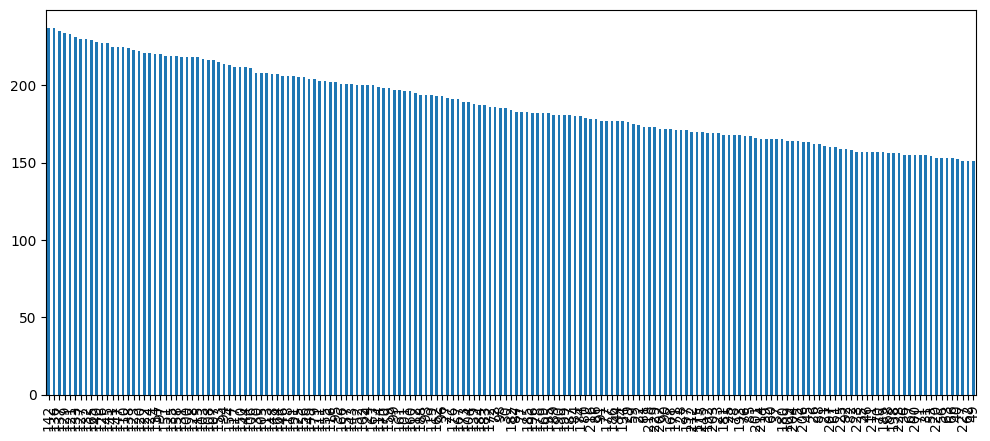

In [ ]:
from os import listdir
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
tok = Tokenizer(num_words=10000)
tok.fit_on_texts(data['cutword'].values)
print("样本数 : ", tok.document_count)
print({k: tok.word_index[k] for k in list(tok.word_index)[:10]})
X= tok.texts_to_sequences(data['cutword'].values)
length=[]
for i in X:
    length.append(len(i))
v_c=pd.Series(length).value_counts()
print(v_c[v_c>150])
v_c[v_c>150].plot(kind='bar',figsize=(12,5))
lis=list(data['label'].unique())
dic1=dict([(key,value)for (value,key) in enumerate(lis)])
dic2=dict([(value,key) for (key,value) in dic1.items()])
dic1,dic2

X= sequence.pad_sequences(X, maxlen=200)
Y=data['label'].map(dic1).values
print("X.shape: ", X.shape)
print("Y.shape: ", Y.shape)
#X=np.array(X)
#Y=np.array(Y)

X_train, X_test, Y_train, Y_test =  train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=0)
X_train.shape,X_test.shape,Y_train.shape, Y_test.shape



Y_test_original=Y_test.copy()
Y_train = to_categorical(Y_train)
Y_test = to_categorical(Y_test)
Y= to_categorical(Y)

print(X_train[100:103])
print(Y_test[:3])
Y_test_original[:3]



# 新段落

In [ ]:
from tensorflow.keras import layers
import tensorflow as tf
from tensorflow import keras
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"),layers.Dense(embed_dim),] )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()

    def call(self, inputs, mask=None):
        if mask is not None:
            mask = mask[:, tf.newaxis, :]
        attention_output = self.attention(inputs, inputs, attention_mask=mask)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim, })
        return config


class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, input_dim, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(input_dim=input_dim, output_dim=output_dim)
        self.position_embeddings = layers.Embedding(input_dim=sequence_length, output_dim=output_dim)
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.output_dim = output_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)

    def get_config(self):
        config = super().get_config()
        config.update({
            "output_dim": self.output_dim,
            "sequence_length": self.sequence_length,
            "input_dim": self.input_dim,})
        return config



# 新段落

In [ ]:
from keras.layers import concatenate # Import concatenate directly from keras.layers
from keras.preprocessing import sequence
from keras.models import Sequential,Model
from keras.layers import Dense,Input, Dropout, Embedding, Flatten,MaxPooling1D,Conv1D,SimpleRNN,LSTM,GRU,Multiply,GlobalMaxPooling1D
from keras.layers import Bidirectional,Activation,BatchNormalization,GlobalAveragePooling1D,MultiHeadAttention
from keras.callbacks import EarlyStopping
np.random.seed(0)
top_words=10000
max_words=200
embed_dim=128
num_labels=7
def build_model(top_words=top_words,max_words=max_words,num_labels=num_labels,mode='LSTM',hidden_dim=[64]):
    if mode=='RNN':
        model = Sequential()
        model.add(Embedding(top_words, input_length=max_words, output_dim=embed_dim, mask_zero=True))
        model.add(Dropout(0.25))
        model.add(SimpleRNN(hidden_dim[0]))
        model.add(Dropout(0.25))
        model.add(Dense(num_labels, activation="softmax"))
    elif mode=='MLP':
        model = Sequential()
        model.add(Embedding(top_words, input_length=max_words, output_dim=embed_dim))#, mask_zero=True
        model.add(Flatten())
        model.add(Dropout(0.25))
        model.add(Dense(hidden_dim[0]))
        model.add(Dropout(0.25))
        model.add(Dense(num_labels, activation="softmax"))
    elif mode=='LSTM':
        model = Sequential()
        model.add(Embedding(top_words, input_length=max_words, output_dim=embed_dim))
        model.add(Dropout(0.25))
        model.add(LSTM(hidden_dim[0]))
        model.add(Dropout(0.25))
        model.add(Dense(num_labels, activation="softmax"))
    elif mode=='GRU':
        model = Sequential()
        model.add(Embedding(top_words, input_length=max_words, output_dim=embed_dim))
        model.add(Dropout(0.25))
        model.add(GRU(hidden_dim[0]))
        model.add(Dropout(0.25))
        model.add(Dense(num_labels, activation="softmax"))
    elif mode=='CNN':        #一维卷积
        model = Sequential()
        model.add(Embedding(top_words, input_length=max_words, output_dim=embed_dim, mask_zero=True))
        model.add(Dropout(0.25))
        model.add(Conv1D(filters=32, kernel_size=3, padding="same",activation="relu"))
        model.add(MaxPooling1D(pool_size=2))
        model.add(Flatten())
        model.add(Dense(hidden_dim[0], activation="relu"))
        model.add(Dropout(0.25))
        model.add(Dense(num_labels, activation="softmax"))
    elif mode=='CNN+LSTM':
        model = Sequential()
        model.add(Embedding(top_words, input_length=max_words, output_dim=embed_dim))
        model.add(Dropout(0.25))
        model.add(Conv1D(filters=32, kernel_size=3, padding="same",activation="relu"))
        model.add(MaxPooling1D(pool_size=2))
        model.add(LSTM(hidden_dim[0]))
        model.add(Dropout(0.25))
        model.add(Dense(num_labels, activation="softmax"))
    elif mode=='BiLSTM':
        model = Sequential()
        model.add(Embedding(top_words, input_length=max_words, output_dim=embed_dim))
        model.add(Bidirectional(LSTM(64)))
        model.add(Dense(hidden_dim[0], activation='relu'))
        model.add(Dropout(0.25))
        model.add(Dense(num_labels, activation='softmax'))
    #下面的网络采用Funcional API实现
    elif mode=='TextCNN':
        inputs = Input(name='inputs',shape=[max_words,], dtype='float64')
        ## 词嵌入使用预训练的词向量
        layer = Embedding(top_words, input_length=max_words, output_dim=embed_dim)(inputs)
        ## 词窗大小分别为3,4,5
        cnn1 = Conv1D(32, 3, padding='same', strides = 1, activation='relu')(layer)
        cnn1 = MaxPooling1D(pool_size=2)(cnn1)
        cnn2 = Conv1D(32, 4, padding='same', strides = 1, activation='relu')(layer)
        cnn2 = MaxPooling1D(pool_size=2)(cnn2)
        cnn3 = Conv1D(32, 5, padding='same', strides = 1, activation='relu')(layer)
        cnn3 = MaxPooling1D(pool_size=2)(cnn3)
        # 合并三个模型的输出向量
        cnn = concatenate([cnn1,cnn2,cnn3], axis=-1)
        x = Flatten()(cnn)
        x = Dense(hidden_dim[0], activation='relu')(x)
        output = Dense(num_labels, activation='softmax')(x)
        model = Model(inputs=inputs, outputs=output)

    elif mode=='Attention':
        inputs = Input(name='inputs',shape=[max_words,], dtype='float64')
        x = Embedding(top_words, input_length=max_words, output_dim=embed_dim, mask_zero=True)(inputs)
        x = MultiHeadAttention(1, key_dim=embed_dim)(x, x,x)
        x = GlobalAveragePooling1D()(x)
        x = Dropout(0.2)(x)
        x = Dense(32, activation='relu')(x)
        output = Dense(num_labels, activation='softmax')(x)
        model = Model(inputs=[inputs], outputs=output)

    elif mode=='MultiHeadAttention':
        inputs = Input(name='inputs',shape=[max_words,], dtype='float64')
        x = Embedding(top_words, input_length=max_words, output_dim=embed_dim, mask_zero=True)(inputs)
        x = MultiHeadAttention(8, key_dim=embed_dim)(x, x,x)
        x = GlobalAveragePooling1D()(x)
        x = Dropout(0.2)(x)
        x = Dense(32, activation='relu')(x)
        output = Dense(num_labels, activation='softmax')(x)
        model = Model(inputs=[inputs], outputs=output)

    elif mode=='Attention+BiLSTM':
        inputs = Input(name='inputs',shape=[max_words,], dtype='float64')
        x = Embedding(top_words, input_length=max_words, output_dim=embed_dim)(inputs)
        x = MultiHeadAttention(2, key_dim=embed_dim)(x, x,x)
        x = Bidirectional(LSTM(hidden_dim[0]))(x)
        x = Dense(64, activation='relu')(x)
        x = Dropout(0.2)(x)
        output = Dense(num_labels, activation='softmax')(x)
        model = Model(inputs=inputs, outputs=output)

    elif mode=='BiGRU+Attention':
        inputs = Input(name='inputs',shape=[max_words,], dtype='float64')
        x = Embedding(top_words, input_length=max_words, output_dim=embed_dim)(inputs)
        x = Bidirectional(GRU(32,return_sequences=True))(x)
        x = MultiHeadAttention(2, key_dim=embed_dim)(x,x,x)
        x = Bidirectional(GRU(32))(x)
        x = Dropout(0.2)(x)
        output = Dense(num_labels, activation='softmax')(x)
        model = Model(inputs=[inputs], outputs=output)

    elif mode=='Transformer':
        inputs = Input(name='inputs',shape=[max_words,], dtype='float64')
        x = Embedding(top_words, input_length=max_words, output_dim=embed_dim, mask_zero=True)(inputs)
        x = TransformerEncoder(embed_dim, 32, 4)(x)
        x = GlobalMaxPooling1D()(x)
        x = Dropout(0.25)(x)
        outputs = Dense(num_labels, activation='softmax')(x)
        model = Model(inputs, outputs)

    elif mode=='PositionalEmbedding+Transformer':
        inputs = Input(name='inputs',shape=[max_words,], dtype='float64')
        x= PositionalEmbedding(sequence_length=max_words, input_dim=top_words, output_dim=embed_dim)(inputs)
        x = TransformerEncoder(embed_dim, 32, 4)(x)
        x = GlobalMaxPooling1D()(x)
        x = Dropout(0.5)(x)
        outputs = Dense(num_labels, activation='softmax')(x)
        model = Model(inputs, outputs)

    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    return model


In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import cohen_kappa_score
def plot_loss(history):
    plt.subplots(1,2,figsize=(10,3))
    plt.subplot(121)
    loss = history.history["loss"]
    epochs = range(1, len(loss)+1)
    val_loss = history.history["val_loss"]
    plt.plot(epochs, loss, "bo", label="Training Loss")
    plt.plot(epochs, val_loss, "r", label="Validation Loss")
    plt.title("Training and Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.subplot(122)
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]
    plt.plot(epochs, acc, "b-", label="Training Acc")
    plt.plot(epochs, val_acc, "r--", label="Validation Acc")
    plt.title("Training and Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.tight_layout()
    plt.show()
def plot_confusion_matrix(model,X_test,Y_test_original):
    prob=model.predict(X_test)
    pred=np.argmax(prob,axis=1)
    pred=pd.Series(pred).map(dic2)
    Y_test_original=pd.Series(Y_test_original).map(dic2)
    table = pd.crosstab(Y_test_original, pred, rownames=['Actual'], colnames=['Predicted'])
    #print(table)
    sns.heatmap(table,cmap='Purples',fmt='.20g', annot=True)
    plt.tight_layout()
    plt.show()
    print(classification_report(Y_test_original, pred))
    print('Kappa'+str(cohen_kappa_score(Y_test_original, pred)))

def evaluation(y_test, y_predict):
    accuracy=classification_report(y_test, y_predict,output_dict=True)['accuracy']
    s=classification_report(y_test, y_predict,output_dict=True)['weighted avg']
    precision=s['precision']
    recall=s['recall']
    f1_score=s['f1-score']
    #kappa=cohen_kappa_score(y_test, y_predict)
    return accuracy,precision,recall,f1_score #, kappa
#定义训练函数
df_eval=pd.DataFrame(columns=['Accuracy','Precision','Recall','F1_score'])
def train_fuc(max_words=max_words,mode='BiLSTM+Attention',batch_size=64,epochs=10,hidden_dim=[64],show_loss=True,show_confusion_matrix=True):
    #构建模型
    model=build_model(max_words=max_words,mode=mode,hidden_dim=hidden_dim)
    print(model.summary())
    es = EarlyStopping(patience=5)
    history=model.fit(X_train, Y_train,batch_size=batch_size,epochs=epochs,validation_split=0.2, verbose=1,callbacks=[es])
    print('——————————-----------------——Finished—————-----------------------------———————')

    #loss, accuracy = model.evaluate(X_test, Y_test)  ;  print("测试数据集的准确度 = {:.4f}".format(accuracy))
    prob=model.predict(X_test) ;  pred=np.argmax(prob,axis=1)
    score=list(evaluation(Y_test_original, pred))
    df_eval.loc[mode,:]=score

    if show_loss:
        plot_loss(history)
    if show_confusion_matrix:
        plot_confusion_matrix(model=model,X_test=X_test,Y_test_original=Y_test_original)





In [ ]:
top_words=10000
max_words=200
batch_size=128
epochs=5
hidden_dim=[64]
show_confusion_matrix=True
show_loss=True

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 200, 128)          1280000   
                                                                 
 flatten_1 (Flatten)         (None, 25600)             0         
                                                                 
 dropout_3 (Dropout)         (None, 25600)             0         
                                                                 
 dense_5 (Dense)             (None, 64)                1638464   
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 7)                 455       
                                                                 
Total params: 2918919 (11.13 MB)
Trainable params: 291

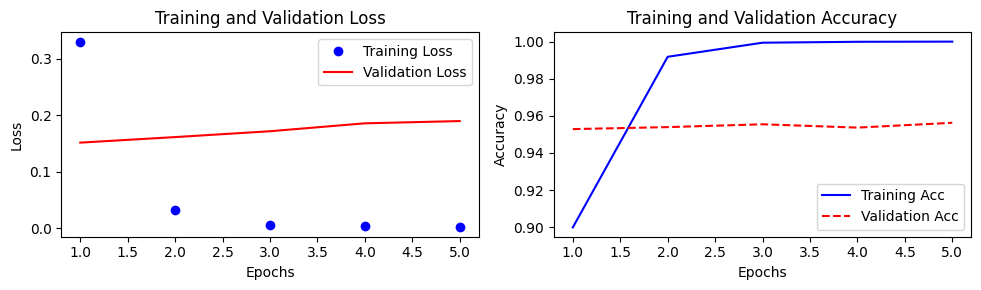

438/438 [==============================] - 3s 6ms/step


/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 23478 (\N{CJK UNIFIED IDEOGRAPH-5BB6}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 23621 (\N{CJK UNIFIED IDEOGRAPH-5C45}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 25151 (\N{CJK UNIFIED IDEOGRAPH-623F}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 20135 (\N{CJK UNIFIED IDEOGRAPH-4EA7}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 25945 (\N{CJK UNIFIED IDEOGRAPH-6559}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 32946 (\N{CJK UNIFIED IDEOGRAPH-80B2}) missing from current font.
  fig.canvas.draw()
/usr

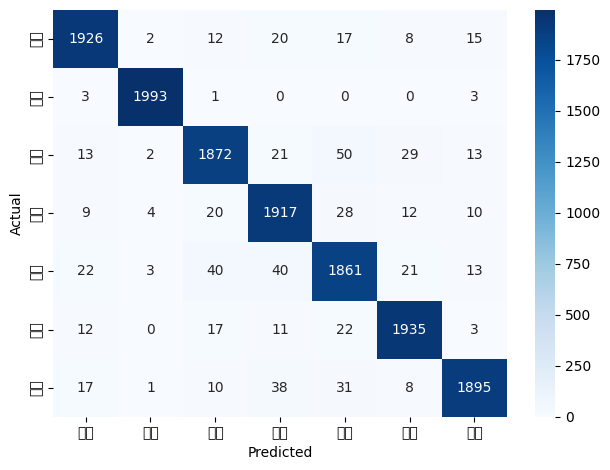

              precision    recall  f1-score   support

          家居       0.96      0.96      0.96      2000
          房产       0.99      1.00      1.00      2000
          教育       0.95      0.94      0.94      2000
          时政       0.94      0.96      0.95      2000
          社会       0.93      0.93      0.93      2000
          科技       0.96      0.97      0.96      2000
          财经       0.97      0.95      0.96      2000

    accuracy                           0.96     14000
   macro avg       0.96      0.96      0.96     14000
weighted avg       0.96      0.96      0.96     14000

科恩Kappa0.9499166666666666


In [ ]:
train_fuc(mode='MLP',batch_size=batch_size,epochs=epochs)

In [ ]:
#X_train= X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
#X_test= X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
train_fuc(mode='CNN',batch_size=batch_size,epochs=epochs)


In [ ]:
model='RNN'
train_fuc(mode=model,batch_size=batch_size,epochs=8)


In [ ]:

train_fuc(mode='LSTM',epochs=epochs)

In [ ]:
train_fuc(mode='CNN+LSTM',epochs=epochs)

In [ ]:
train_fuc(mode='BiLSTM',epochs=epochs)

In [ ]:
train_fuc(mode='TextCNN',epochs=3)

In [ ]:
train_fuc(mode='Attention',epochs=4)

In [ ]:
train_fuc(mode='MultiHeadAttention',epochs=3)

In [ ]:
train_fuc(mode='Attention+BiLSTM',epochs=8)

In [ ]:
train_fuc(mode='BiGRU+Attention',epochs=4)

Model: "model_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 200)]             0         
                                                                 
 embedding_20 (Embedding)    (None, 200, 128)          1280000   
                                                                 
 transformer_encoder_16 (Tr  (None, 200, 128)          272672    
 ansformerEncoder)                                               
                                                                 
 global_max_pooling1d_16 (G  (None, 128)               0         
 lobalMaxPooling1D)                                              
                                                                 
 dropout_26 (Dropout)        (None, 128)               0         
                                                                 
 dense_62 (Dense)            (None, 7)                 903

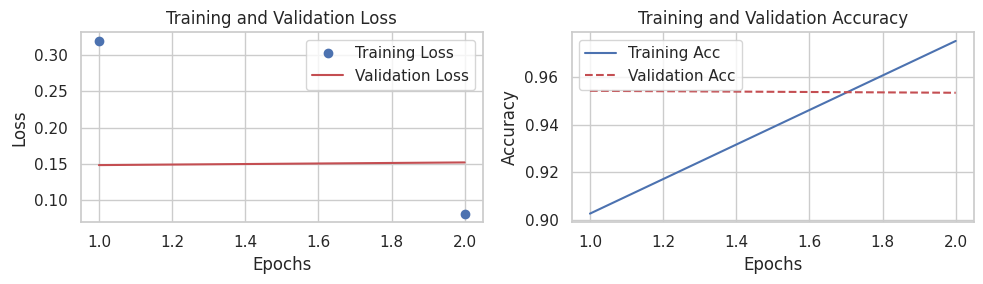

438/438 [==============================] - 112s 256ms/step


/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 23478 (\N{CJK UNIFIED IDEOGRAPH-5BB6}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 23621 (\N{CJK UNIFIED IDEOGRAPH-5C45}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 25151 (\N{CJK UNIFIED IDEOGRAPH-623F}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 20135 (\N{CJK UNIFIED IDEOGRAPH-4EA7}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 25945 (\N{CJK UNIFIED IDEOGRAPH-6559}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 32946 (\N{CJK UNIFIED IDEOGRAPH-80B2}) missing from current font.
  fig.canvas.draw()
/usr

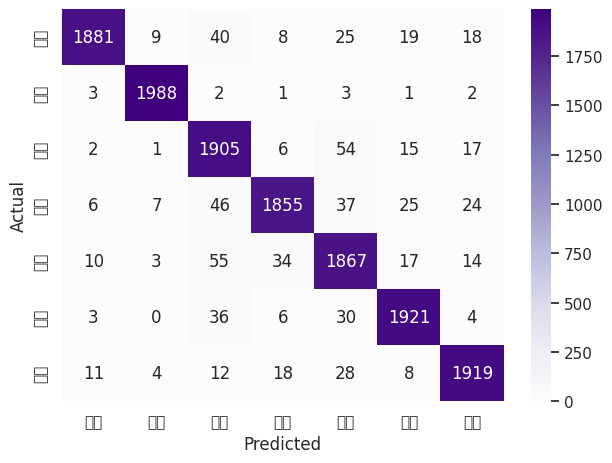

              precision    recall  f1-score   support

          家居       0.98      0.94      0.96      2000
          房产       0.99      0.99      0.99      2000
          教育       0.91      0.95      0.93      2000
          时政       0.96      0.93      0.94      2000
          社会       0.91      0.93      0.92      2000
          科技       0.96      0.96      0.96      2000
          财经       0.96      0.96      0.96      2000

    accuracy                           0.95     14000
   macro avg       0.95      0.95      0.95     14000
weighted avg       0.95      0.95      0.95     14000

科恩Kappa0.9446666666666667


In [ ]:
train_fuc(mode='Transformer',epochs=2)

Model: "model_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 200)]             0         
                                                                 
 positional_embedding_12 (P  (None, 200, 128)          1305600   
 ositionalEmbedding)                                             
                                                                 
 transformer_encoder_25 (Tr  (None, 200, 128)          272672    
 ansformerEncoder)                                               
                                                                 
 global_max_pooling1d_25 (G  (None, 128)               0         
 lobalMaxPooling1D)                                              
                                                                 
 dropout_31 (Dropout)        (None, 128)               0         
                                                          

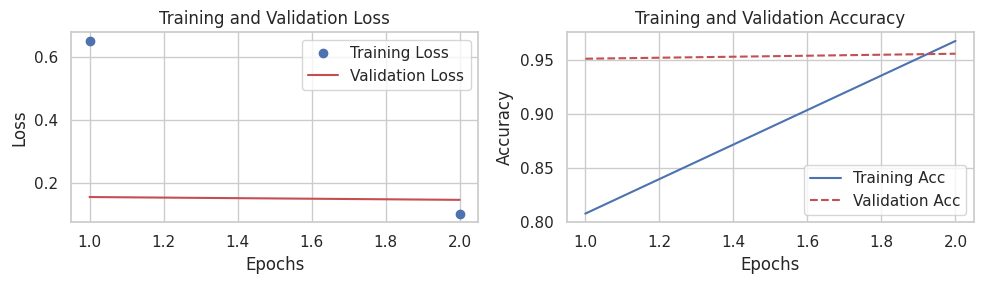

438/438 [==============================] - 127s 289ms/step


/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 23478 (\N{CJK UNIFIED IDEOGRAPH-5BB6}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 23621 (\N{CJK UNIFIED IDEOGRAPH-5C45}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 25151 (\N{CJK UNIFIED IDEOGRAPH-623F}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 20135 (\N{CJK UNIFIED IDEOGRAPH-4EA7}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 25945 (\N{CJK UNIFIED IDEOGRAPH-6559}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 32946 (\N{CJK UNIFIED IDEOGRAPH-80B2}) missing from current font.
  fig.canvas.draw()
/usr

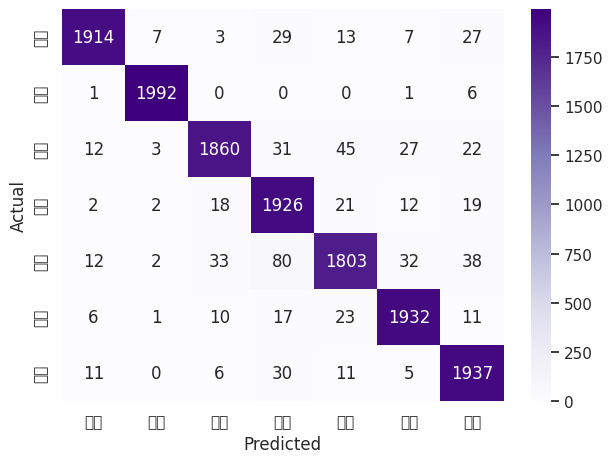

              precision    recall  f1-score   support

          家居       0.98      0.96      0.97      2000
          房产       0.99      1.00      0.99      2000
          教育       0.96      0.93      0.95      2000
          时政       0.91      0.96      0.94      2000
          社会       0.94      0.90      0.92      2000
          科技       0.96      0.97      0.96      2000
          财经       0.94      0.97      0.95      2000

    accuracy                           0.95     14000
   macro avg       0.95      0.95      0.95     14000
weighted avg       0.95      0.95      0.95     14000

科恩Kappa0.947


In [ ]:
train_fuc(mode='PositionalEmbedding+Transformer',batch_size=batch_size,epochs=2)

In [ ]:
df_eval.assign(s=df_eval.sum(axis=1))#['s'].idxmax()

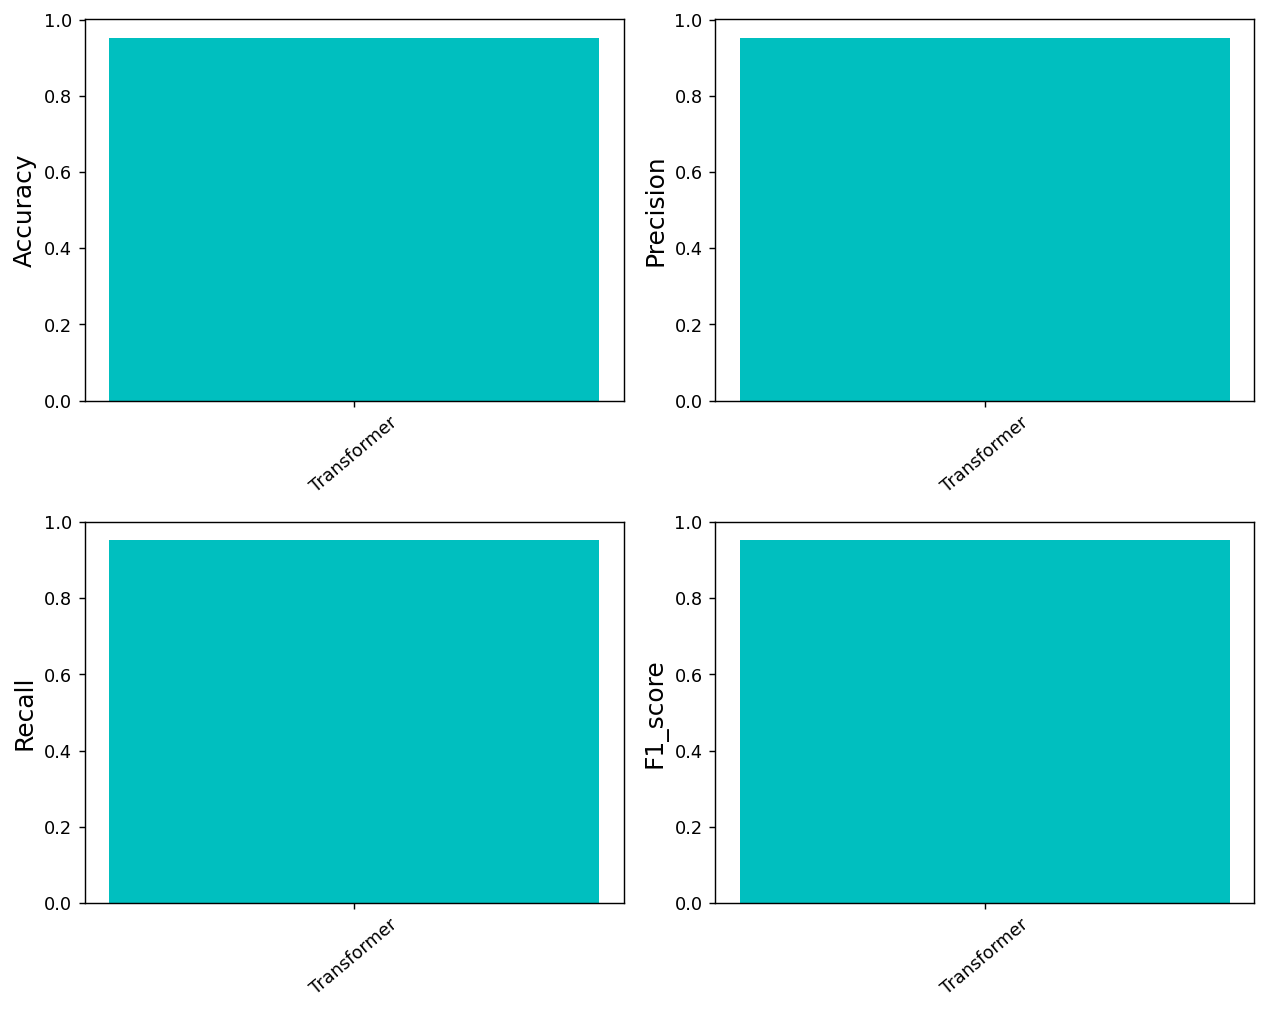

In [ ]:
bar_width = 0.4
colors=['c', 'b', 'g', 'tomato', 'm', 'y', 'lime', 'k','orange','pink','grey','tan','gold','r']
fig, ax = plt.subplots(2,2,figsize=(10,8),dpi=128)
for i,col in enumerate(df_eval.columns):
    n=int(str('22')+str(i+1))
    plt.subplot(n)
    df_col=df_eval[col]
    m =np.arange(len(df_col))
    plt.bar(x=m,height=df_col.to_numpy(),width=bar_width,color=colors)

    #plt.xlabel('Methods',fontsize=12)
    names=df_col.index
    plt.xticks(range(len(df_col)),names,fontsize=10)
    plt.xticks(rotation=40)
    plt.ylabel(col,fontsize=14)

plt.tight_layout()
#plt.savefig('柱状图.jpg',dpi=512)
plt.show()

In [ ]:
import jieba
import pandas as pd
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
model=build_model(max_words=200,mode='Transformer',hidden_dim=[64])
history=model.fit(X,Y,batch_size=batch_size,epochs=2,verbose=0)
def predict_newkind(new_txt,token=tok):
    dic2={0:'教育',1:'科技',2:'社会',3:'时政',4:'财经',5:'房产',6:'家居'}
    new_txt=txt_cut(new_txt)
    new_text_seq = tok.texts_to_sequences([new_txt])
    new_text_seq_padded = sequence.pad_sequences(new_text_seq, maxlen=200)
    predictions = model.predict(new_text_seq_padded)
    predicted_class = np.argmax(predictions, axis=1)
    return dic2[predicted_class[0]], predicted_class[0]
url = "https://raw.githubusercontent.com/MarcyChen-ruixin/AIM-5001/main/weibo_hot_searches.csv"
df = pd.read_csv(url)
stopwords=pd.read_csv("/content/drive/MyDrive/tyc.txt",index_col=False,quoting=3,  #停用词
                         sep="\t",names=['stopword'], encoding='utf-8')
def preprocess_text(text):
    words = jieba.lcut(text)  # 使用 jieba 进行分词
    words = [word for word in words if word not in stopwords]  # 去除停用词
    return ' '.join(words)

df['processed_text'] = df['Hot Search'].astype(str).apply(preprocess_text)
# Process text data
texts = df['processed_text'].astype(str)
predicted_labels = []
predicted_Num = []
for text in texts:
    label, numeric_label = predict_newkind(text, token=tok)  # 使用正确的参数名
    predicted_labels.append(label)
    predicted_Num.append(numeric_label)


# Add predicted labels to DataFrame
df['predicted_label'] = predicted_labels
df['predicted_Num'] = predicted_Num
# Display DataFrame with predicted labels
print(df.head())

1/1 [==============================] - 0s 33ms/step
             Timestamp        Hot Search            processed_text  \
0  2024-06-25 18:59:23           刘亦菲回复林一                 刘亦菲 回复 林一   
1  2024-06-25 18:59:23    男生查分后默默去做饭妈妈秒懂    男生 查分 后 默默 去 做饭 妈妈 秒 懂   
2  2024-06-25 18:59:23       嫦娥六号返回器安全着陆          嫦娥 六号 返回 器 安全 着陆   
3  2024-06-25 18:59:23  蚂蚁保上预定利率3.0%的增额寿    蚂蚁 保上 预定 利率 3.0% 的 增额寿   
4  2024-06-25 18:59:23  我考了696分我同桌考了703分  我考 了 696 分 我 同桌 考了 703 分   

  predicted_label  predicted_Num  
0              家居              6  
1              家居              6  
2              科技              1  
3              财经              4  
4              社会              2  


In [ ]:
print(df.head(60))

Cluster 家居: Top 5 Keywords: 刘亦菲 回应 不吃 麦 赵今
Cluster 科技: Top 5 Keywords: 看 李雪琴 游泳 第一次 蛋糕
Cluster 财经: Top 5 Keywords: 到底 摸 赵露思 热度 开播
Cluster 社会: Top 5 Keywords: 分 女儿 不想 视频 北大
Cluster 教育: Top 5 Keywords: 大学 高考 省读 人不爱出 分
Cluster 时政: Top 5 Keywords: 盘旋 南海 投放 机在 物体
Cluster 房产: Top 5 Keywords: 北京 张杰 优化 房地产 政策


<ipython-input-72-c35f3f0a96f3>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='predicted_Num', data=df, palette="viridis")


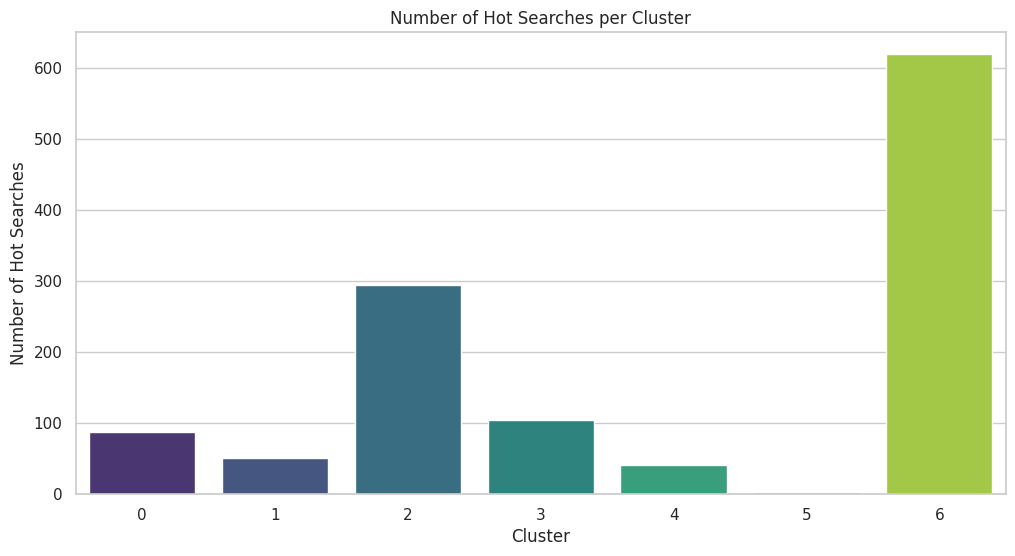

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import jieba
import pandas as pd

# 加载停用词列表
stopwords = pd.read_csv("/content/drive/MyDrive/tyc.txt", index_col=False, quoting=3, sep="\t", names=['stopword'], encoding='utf-8')['stopword'].tolist()
stopwords = set([word.strip() for word in stopwords])

def plot_keywords_per_cluster(df):
    # 根据预测标签进行聚类
    cluster_labels = df['predicted_label'].unique()

    # 打印每一类的前五个关键词
    for label in cluster_labels:
        cluster_text = ' '.join(df[df['predicted_label'] == label]['processed_text'])
        # 分词并去除停用词
        words = jieba.lcut(cluster_text)
        words = [word for word in words if word not in stopwords and word.strip() != '']
        # 统计词频并选取前五个关键词
        word_counts = pd.Series(words).value_counts()
        cluster_keywords = ' '.join(word_counts.index[:5])
        print(f"Cluster {label}: Top 5 Keywords: {cluster_keywords}")

    # 绘制每一类的分布图
    sns.set(style="whitegrid")
    plt.figure(figsize=(12, 6))
    sns.countplot(x='predicted_Num', data=df, palette="viridis")
    plt.title("Number of Hot Searches per Cluster")
    plt.xlabel("Cluster")
    plt.ylabel("Number of Hot Searches")
    plt.show()

plot_keywords_per_cluster(df)


In [ ]:
!pip install openai
import openai

openai.api_key = "your own API"
examples = [
    {"title": "刘亦菲回复林一", "label": "文娱"},
    {"title": "蚂蚁保上预定利率3.0%的增额寿", "label": "财经"},
    {"title": "清华告诉你北京到底有谁在", "label": "教育"},
    {"title": "嫦娥六号返回器安全着陆", "label": "科技"},
    {"title": "男子用麻精药品迷奸多名女性被判无期", "label": "社会"}
]

def convert_to_sql(natural_language_text):
  prompt = "以下是一些新闻标题和它们的分类标签：\n"
  for example in examples:
    prompt += f"- 标题: {example['title']}, 标签: {example['label']}\n"
  prompt += f"\n请根据以上例子，为我接下来输入的新闻标题分配一个合适的标签，请一定不要衍生新标签，特别注意不要在标签栏里出现（健康，家庭，还有交通，这些统一标签为社会），标签范围只能是（文娱，财经，教育，科技，社会（不要让标签里出现健康，交通，家庭之类的非标签词），体育，国际）：\n标题: {natural_language_text}\n标签:"

  response = openai.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[{"role": "user", "content": prompt}],
        max_tokens=100
    )

  return response.choices[0].message.content.strip()
natural_language_text = "裘德 歌手."
sql_query = convert_to_sql(natural_language_text)

print(f"Natural Language Text: {natural_language_text}")
print(f"SQL Query: {sql_query}")

Natural Language Text: 裘德 歌手.
SQL Query: 标签: 文娱


In [ ]:
!pip install openai
import openai
import pandas as pd
from google.colab import files
openai.api_key = "your own API"
examples = [
    {"title": "刘亦菲回复林一", "label": "文娱"},
    {"title": "蚂蚁保上预定利率3.0%的增额寿", "label": "财经"},
    {"title": "清华告诉你北京到底有谁在", "label": "教育"},
    {"title": "嫦娥六号返回器安全着陆", "label": "科技"},
    {"title": "男子用麻精药品迷奸多名女性被判无期", "label": "社会"}
]

def convert_to_sql(natural_language_text):
    prompt = "以下是一些新闻标题和它们的分类标签：\n"
    for example in examples:
        prompt += f"- 标题: {example['title']}, 标签: {example['label']}\n"
    prompt += f"\n请根据以上例子，为我接下来输入的新闻标题分配一个合适的标签，请一定不要衍生新标签，特别注意不要在标签栏里出现（健康，家庭，还有交通，这些统一标签为社会），标签范围只能是（文娱，财经，教育，科技，社会（不要让标签里出现健康，交通，家庭之类的非标签词），体育，国际）：\n标题: {natural_language_text}\n标签:"

    response = openai.chat.completions.create(
        model="gpt-4-turbo",
        messages=[{"role": "user", "content": prompt}],
        max_tokens=100
    )

    label = response.choices[0].message.content.strip()


    if "标签:" in label:
        label = label.split("标签:")[1].strip()


    if label not in ["文娱", "财经", "教育", "科技", "社会", "体育", "国际"]:
        label = "社会"

    return label


url = "https://raw.githubusercontent.com/MarcyChen-ruixin/AIM-5001/main/weibo_hot_searches.csv"
df = pd.read_csv(url)
labels = []
for natural_language_text in df['Hot Search']:
    sql_query = convert_to_sql(natural_language_text)
    labels.append(sql_query)

df['label'] = labels
print(df.head(60))
output_csv_path = 'weibo_hot_searches_with_labels_final.csv'
df.to_csv(output_csv_path, index=False)
files.download(output_csv_path)


print(f"DataFrame with labels saved to {output_csv_path}")

              Timestamp         Hot Search label
0   2024-06-25 18:59:23            刘亦菲回复林一    文娱
1   2024-06-25 18:59:23     男生查分后默默去做饭妈妈秒懂    教育
2   2024-06-25 18:59:23        嫦娥六号返回器安全着陆    科技
3   2024-06-25 18:59:23   蚂蚁保上预定利率3.0%的增额寿    财经
4   2024-06-25 18:59:23   我考了696分我同桌考了703分    教育
5   2024-06-25 18:59:23       清华告诉你北京到底有谁在    教育
6   2024-06-25 18:59:23        那英 我根本记不住歌词    文娱
7   2024-06-25 18:59:23              腾讯四连爆    文娱
8   2024-06-25 18:59:23    北京警方通报65岁男子捂女孩嘴    社会
9   2024-06-25 18:59:23        梁永棋抱着喝醉的王星越    文娱
10  2024-06-25 18:59:23  凡尔赛男孩称考得不好全省排名一千多    教育
11  2024-06-25 18:59:23        金靖刘胜瑛真的一起怀孕    社会
12  2024-06-25 18:59:23         刘亦菲发文感谢所有人    文娱
13  2024-06-25 18:59:23  男子用麻精药品迷奸多名女性被判无期    社会
14  2024-06-25 18:59:23       喜茶新品名小奶栀被指擦边    文娱
15  2024-06-25 18:59:23  被境外毒枭悬赏人头的缉毒警有话要说    社会
16  2024-06-25 18:59:23              裘德 歌手    文娱
17  2024-06-25 18:59:23          林一晒与刘亦菲合照    文娱
18  2024-06-25 18:59:23     只有川渝人才知道他演的有多像    文娱
19  2024-06-25 18:59

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

DataFrame with labels saved to weibo_hot_searches_with_labels_final.csv


Cluster 文娱: Top 5 Keywords: 刘亦菲 diss 回应 林一 麦
Cluster 教育: Top 5 Keywords: 分 高考 北大 黄亦玫 复旦
Cluster 科技: Top 5 Keywords: 消息 59 秒 原来 一分钟
Cluster 财经: Top 5 Keywords: 北京 万 万元 年少 100
Cluster 社会: Top 5 Keywords: 女儿 后 父亲 不吃 视频
Cluster 体育: Top 5 Keywords: 巴黎 李雪琴 游泳 死亡 欧洲杯
Cluster 国际: Top 5 Keywords: 美军 南海 盘旋 物体 投放


<ipython-input-38-605a150a87ec>:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label_id', data=df, palette="viridis")


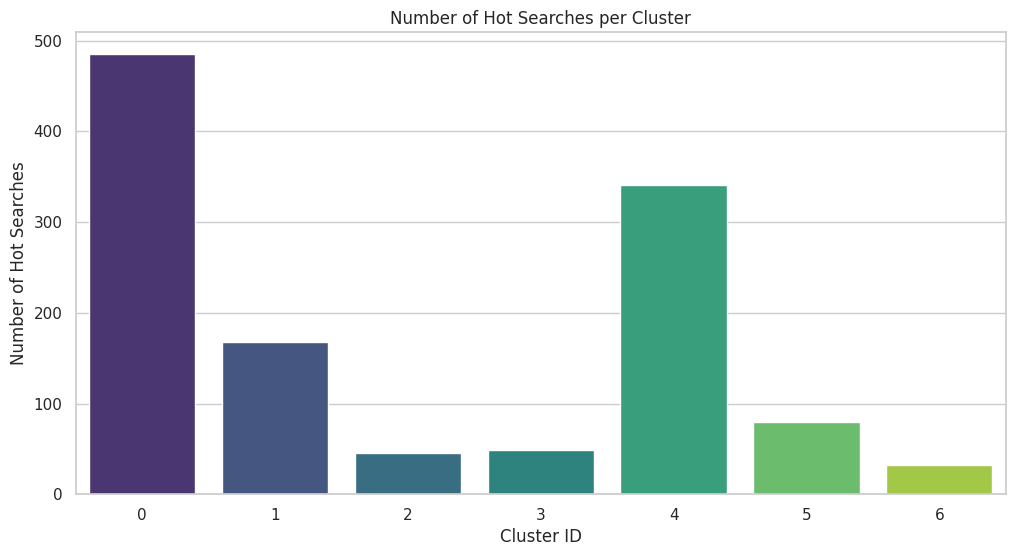

,Timestamp,Hot Search,label,processed_text,label_id
0,2024-06-25 18:59:23,刘亦菲回复林一,文娱,刘亦菲 回复 林一,0
1,2024-06-25 18:59:23,男生查分后默默去做饭妈妈秒懂,教育,男生 查分 后 默默 去 做饭 妈妈 秒 懂,1
2,2024-06-25 18:59:23,嫦娥六号返回器安全着陆,科技,嫦娥 六号 返回 器 安全 着陆,2
3,2024-06-25 18:59:23,蚂蚁保上预定利率3.0%的增额寿,财经,蚂蚁 保上 预定 利率 3.0% 增额寿,3
4,2024-06-25 18:59:23,我考了696分我同桌考了703分,教育,我考 696 分 同桌 考了 703 分,1
...,...,...,...,...,...
1195,2024-06-26 17:59:49,何洁尚雯婕合唱想唱就唱,文娱,何洁 尚雯婕 合唱 想 唱 唱,0
1196,2024-06-26 17:59:49,谁说站在光里的才算是英雄,文娱,说 站 光里 算是 英雄,0
1197,2024-06-26 17:59:49,林一鼻子,文娱,林一 鼻子,0
1198,2024-06-26 17:59:49,原神4.7版本,科技,原神 4.7 版本,2


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import jieba
import pandas as pd

# 加载停用词列表
stopwords = pd.read_csv("/content/drive/MyDrive/tyc.txt", index_col=False, quoting=3, sep="\t", names=['stopword'], encoding='utf-8')['stopword'].tolist()
stopwords = set([word.strip() for word in stopwords])

# 示例数据，假设已经加载了df数据框
def preprocess_text(text):
    words = jieba.lcut(text)  # 使用 jieba 进行分词
    words = [word for word in words if word not in stopwords]  # 去除停用词
    return ' '.join(words)

df['processed_text'] = df['Hot Search'].astype(str).apply(preprocess_text)

def plot_keywords_per_cluster(df):
    # 根据预测标签进行聚类
    cluster_labels = df['label'].unique()
    label_map = {label: idx for idx, label in enumerate(cluster_labels)}  # 创建标签到编号的映射

    # 打印每一类的前五个关键词
    for label in cluster_labels:
        cluster_text = ' '.join(df[df['label'] == label]['processed_text'])
        # 分词并去除停用词
        words = jieba.lcut(cluster_text)
        words = [word for word in words if word not in stopwords and word.strip() != '']
        # 统计词频并选取前五个关键词
        word_counts = pd.Series(words).value_counts()
        cluster_keywords = ' '.join(word_counts.index[:5])
        print(f"Cluster {label}: Top 5 Keywords: {cluster_keywords}")

    # 替换标签为编号
    df['label_id'] = df['label'].map(label_map)

    # 绘制每一类的分布图
    sns.set(style="whitegrid")
    plt.figure(figsize=(12, 6))
    sns.countplot(x='label_id', data=df, palette="viridis")
    plt.title("Number of Hot Searches per Cluster")
    plt.xlabel("Cluster ID")
    plt.ylabel("Number of Hot Searches")

    plt.show()

plot_keywords_per_cluster(df)
df


Cluster 文娱:
  热搜: 刘亦菲回复林一
  关键词: 刘亦菲 回复 林一
  热搜: 那英 我根本记不住歌词
  关键词: 那英 根本 记不住 歌词
  热搜: 腾讯四连爆
  关键词: 腾讯 四连爆

Cluster 教育:
  热搜: 男生查分后默默去做饭妈妈秒懂
  关键词: 男生 查分 后 默默 去 做饭 妈妈 秒 懂
  热搜: 我考了696分我同桌考了703分
  关键词: 我考 696 分 同桌 考了 703 分
  热搜: 清华告诉你北京到底有谁在
  关键词: 清华 告诉 北京 到底

Cluster 科技:
  热搜: 嫦娥六号返回器安全着陆
  关键词: 嫦娥 六号 返回 器 安全 着陆
  热搜: 嫦娥六号返回器安全着陆
  关键词: 嫦娥 六号 返回 器 安全 着陆
  热搜: 第一次知道这么吵的虫子长啥样
  关键词: 第一次 知道 吵 虫子 样

Cluster 财经:
  热搜: 蚂蚁保上预定利率3.0%的增额寿
  关键词: 蚂蚁 保上 预定 利率 3.0% 增额寿
  热搜: 存钱很厉害的人都有一个共性
  关键词: 存钱 厉害 人 共性
  热搜: 存钱很厉害的人都有一个共性
  关键词: 存钱 厉害 人 共性

Cluster 社会:
  热搜: 北京警方通报65岁男子捂女孩嘴
  关键词: 北京警方 通报 65 岁 男子 捂 女孩 嘴
  热搜: 金靖刘胜瑛真的一起怀孕
  关键词: 金靖 刘胜瑛 真的 一起 怀孕
  热搜: 男子用麻精药品迷奸多名女性被判无期
  关键词: 男子 用麻精 药品 迷奸 多名 女性 被判 无期

Cluster 体育:
  热搜: 法国vs波兰
  关键词: 法国 vs 波兰
  热搜: 荷兰2比3奥地利
  关键词: 荷兰 奥地利
  热搜: 法国1比1波兰
  关键词: 法国 波兰

Cluster 国际:
  热搜: 日本卖的西瓜皮是谁啃的
  关键词: 日本 卖 西瓜皮 啃
  热搜: 希腊开始施行一周工作6天
  关键词: 希腊 施行 一周 工作 天
  热搜: 加沙平均每天10名儿童失去腿
  关键词: 加沙 平均 每天 10 名 儿童 失去 腿


<ipython-input-39-3bfb61906326>:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label_id', data=df, palette="viridis")


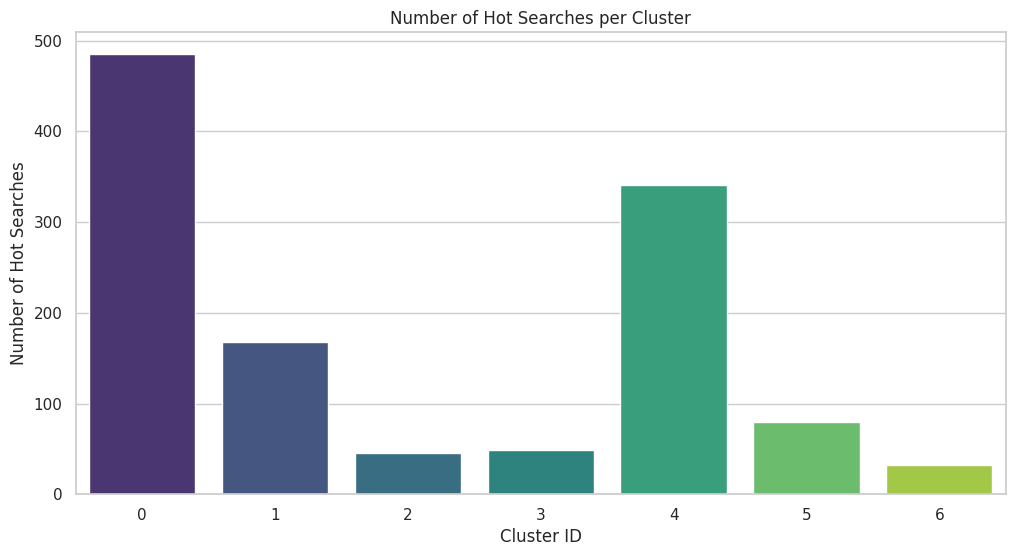

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import jieba
import pandas as pd

# 加载停用词列表
stopwords = pd.read_csv("/content/drive/MyDrive/tyc.txt", index_col=False, quoting=3, sep="\t", names=['stopword'], encoding='utf-8')['stopword'].tolist()
stopwords = set([word.strip() for word in stopwords])

# 示例数据，假设已经加载了df数据框
def preprocess_text(text):
    words = jieba.lcut(text)  # 使用 jieba 进行分词
    words = [word for word in words if word not in stopwords]  # 去除停用词
    return ' '.join(words)

df['processed_text'] = df['Hot Search'].astype(str).apply(preprocess_text)

def plot_keywords_per_cluster(df):
    # 根据预测标签进行聚类
    cluster_labels = df['label'].unique()
    label_map = {label: idx for idx, label in enumerate(cluster_labels)}  # 创建标签到编号的映射

    # 打印每个类别的前三名热搜及其关键词
    for label in cluster_labels:
        print(f"\nCluster {label}:")
        cluster_df = df[df['label'] == label].head(3)  # 获取前三名热搜
        for idx, row in cluster_df.iterrows():
            print(f"  热搜: {row['Hot Search']}")
            words = jieba.lcut(row['Hot Search'])
            words = [word for word in words if word not in stopwords and word.strip() != '']
            keywords = ' '.join(words)
            print(f"  关键词: {keywords}")

    # 替换标签为编号
    df['label_id'] = df['label'].map(label_map)

    # 绘制每一类的分布图
    sns.set(style="whitegrid")
    plt.figure(figsize=(12, 6))
    sns.countplot(x='label_id', data=df, palette="viridis")
    plt.title("Number of Hot Searches per Cluster")
    plt.xlabel("Cluster ID")
    plt.ylabel("Number of Hot Searches")
    plt.show()

plot_keywords_per_cluster(df)
